# LECTURE: FINANCIAL DATA ANALYSIS WITH PYTHON - Porflolios

**Lecture Workflow:**
1.  **Part 1 (Foundations):** A detailed lecture on Time Series Analysis concepts.
2.  **Part 2:** Apply a Train/Test workflow. Train sequential optimization models (n-assets, k-assets) on historical data, then objectively test them on future data.
3.  **Part 3 & 4:** Summary and References.

## PART 1: FOUNDATIONS OF TIME SERIES ANALYSIS

### 1.1: Setup and Global Imports

We will install and import all necessary libraries for the entire lecture here.

In [1]:
# --- Install Libraries ---
# Run once if you don't have them
# !pip install yfinance pandas numpy matplotlib seaborn PyPortfolioOpt

# --- Imports for Data Analysis (Part 1 & 2) ---
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy # To copy objects

# --- Imports for Portfolio Optimization (Part 2) ---
import itertools # To create combinations
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import plotting 

# --- Global Settings ---
sns.set_theme(style="darkgrid")
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 7)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

print("All libraries imported and settings configured.")

All libraries imported and settings configured.


### 1.2: Load Data for Part 1 (Introductory Data)

To learn the foundational concepts, we will load a large dataset (5 years) as an example.

In [2]:
intro_tickers = ['AAPL', 'MSFT', 'GOOGL', 'SPY']
years_of_data = 5 # Load 5 years to have enough data for examples

# Load data
intro_end_date = pd.Timestamp.today()
intro_start_date = intro_end_date - pd.DateOffset(years=years_of_data)

print(f"Loading data for {len(intro_tickers)} tickers (For Part 1 introduction only)")

try:
    intro_raw_data = yf.download(intro_tickers, start=intro_start_date, end=intro_end_date)['Close']
    intro_raw_data = intro_raw_data.ffill().dropna() 
    print("Introductory data loaded successfully.")
    print(intro_raw_data.tail())
except Exception as e:
    print(f"ERROR: {e}")

Loading data for 4 tickers (For Part 1 introduction only)


C:\Users\Admin\AppData\Local\Temp\ipykernel_14072\1556432947.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  intro_raw_data = yf.download(intro_tickers, start=intro_start_date, end=intro_end_date)['Close']
[*********************100%***********************]  4 of 4 completed

Introductory data loaded successfully.
Ticker            AAPL       GOOGL        MSFT         SPY
Date                                                      
2025-11-11  275.250000  291.309998  508.679993  683.000000
2025-11-12  273.470001  286.709991  511.140015  683.380005
2025-11-13  272.950012  278.570007  503.290009  672.039978
2025-11-14  272.410004  276.410004  510.179993  671.929993
2025-11-17  267.459991  285.019989  507.489990  665.669983


### 1.3. Time Series

- **Concept:** A **time series** is a sequence of data points indexed in time order. Its most critical characteristic is **time dependence**; the order of the data is paramount.
- **Tool:** In `pandas`, this is represented by a `DatetimeIndex`. This special index allows for intelligent access, slicing, and processing based on dates/months/years.
- **Code:**

In [3]:
print(f"Index Type: {type(intro_raw_data.index)}")

# Benefit of DatetimeIndex: Slicing
print("\nData from 2023:")
# We can slice using a 'YYYY-MM-DD' string or just 'YYYY'
print(intro_raw_data.loc['2023'].head())

Index Type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>

Data from 2023:
Ticker            AAPL      GOOGL        MSFT         SPY
Date                                                     
2023-01-03  123.211205  88.509544  234.423584  367.150787
2023-01-04  124.482040  87.476669  224.169144  369.985260
2023-01-05  123.161942  85.609543  217.525284  365.762451
2023-01-06  127.693596  86.741722  220.088852  374.150146
2023-01-09  128.215714  87.417068  222.231720  373.938019


### 1.4. Timezones

- **Concept:** Time data can be 'naive' (unaware of timezones) or 'aware' (has timezone information). Financial data must always be handled carefully regarding timezones (e.g., NYSE opening time vs. London time).
- **Tools:** 
  - `tz_localize(timezone_name)`: Assigns a timezone to naive data. Used once.
  - `tz_convert(timezone_name)`: Converts aware data from one timezone to another.
- **Code:**

In [4]:
print(f"Original Timezone Info: {intro_raw_data.index.tz}")

try:
    # 1. Localize (Assign the original market timezone - New York)
    data_localized = intro_raw_data.tz_localize('America/New_York', ambiguous='infer')
    print(f"Timezone after localization: {data_localized.index.tz}")
    print("New York Time:")
    print(data_localized.head(1))

    # 2. Convert (To Vietnam time)
    data_hcm = data_localized.tz_convert('Asia/Ho_Chi_Minh')
    print(f"\nTimezone after conversion: {data_hcm.index.tz}")
    print("Vietnam Time (corresponding):")
    print(data_hcm.head(1))
except TypeError as e:
    print(f"Error: {e}. Data may already be timezone-aware.")

Original Timezone Info: None
Timezone after localization: America/New_York
New York Time:
Ticker                           AAPL      GOOGL        MSFT         SPY
Date                                                                    
2020-11-18 00:00:00-05:00  114.896568  86.435837  202.918716  332.145905

Timezone after conversion: Asia/Ho_Chi_Minh
Vietnam Time (corresponding):
Ticker                           AAPL      GOOGL        MSFT         SPY
Date                                                                    
2020-11-18 12:00:00+07:00  114.896568  86.435837  202.918716  332.145905


- **Observation:** 00:00 (midnight) New York time (UTC-4 or -5) corresponds to 11:00 (or 12:00) AM Vietnam time (UTC+7). Timezone handling is critical when working with high-frequency (intraday) data.

### 1.5. Resampling (Changing Frequency)

- **Concept:** Resampling is the process of changing the frequency of data (e.g., from daily to monthly, or daily to hourly). There are 2 types:
  1. **Downsampling:** Aggregating data from a high frequency to a low frequency (e.g., daily -> monthly). Requires an **aggregation function**.
  2. **Upsampling:** Converting data from a low frequency to a high frequency (e.g., daily -> hourly). Requires a **filling method**.
- **Tools:**
  - `data.resample(new_frequency)`: Creates a Resampler object.
  - **Aggregation (Downsampling):** `.mean()`, `.last()`, `.sum()`, `.ohlc()`.
  - **Filling (Upsampling):** `.ffill()` (forward-fill), `.bfill()` (back-fill), `.asfreq()` (creates `NaN`).
- **Code (Downsampling):**

In [5]:
# Use 'AAPL' as an example
aapl = intro_raw_data[['AAPL']].copy().dropna()

# Downsampling: Daily -> Monthly ('M')
# We take the last value of each month
aapl_monthly = aapl.resample('M').last()
print("--- Monthly Data (Last value) ---")
print(aapl_monthly.head())

# Downsampling: Create weekly OHLC (Open-High-Low-Close) ('W')
aapl_ohlc_weekly = aapl['AAPL'].resample('W').ohlc()
print("\n--- Weekly OHLC Data --- (Open, High, Low, Close)")
print(aapl_ohlc_weekly.head())

--- Monthly Data (Last value) ---
Ticker            AAPL
Date                  
2020-11-30  115.889481
2020-12-31  129.167389
2021-01-31  128.456802
2021-02-28  118.217224
2021-03-31  119.084892

--- Weekly OHLC Data --- (Open, High, Low, Close)
                  open        high         low       close
Date                                                      
2020-11-22  114.896568  115.490387  114.224892  114.224892
2020-11-29  110.827553  113.494797  110.827553  113.494797
2020-12-06  115.889481  119.812508  115.889481  119.004532
2020-12-13  120.464714  121.078011  118.547028  119.160286
2020-12-20  118.547028  125.283302  118.547028  123.297493


C:\Users\Admin\AppData\Local\Temp\ipykernel_14072\3466493821.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  aapl_monthly = aapl.resample('M').last()


- **Visualization (Downsampling):**

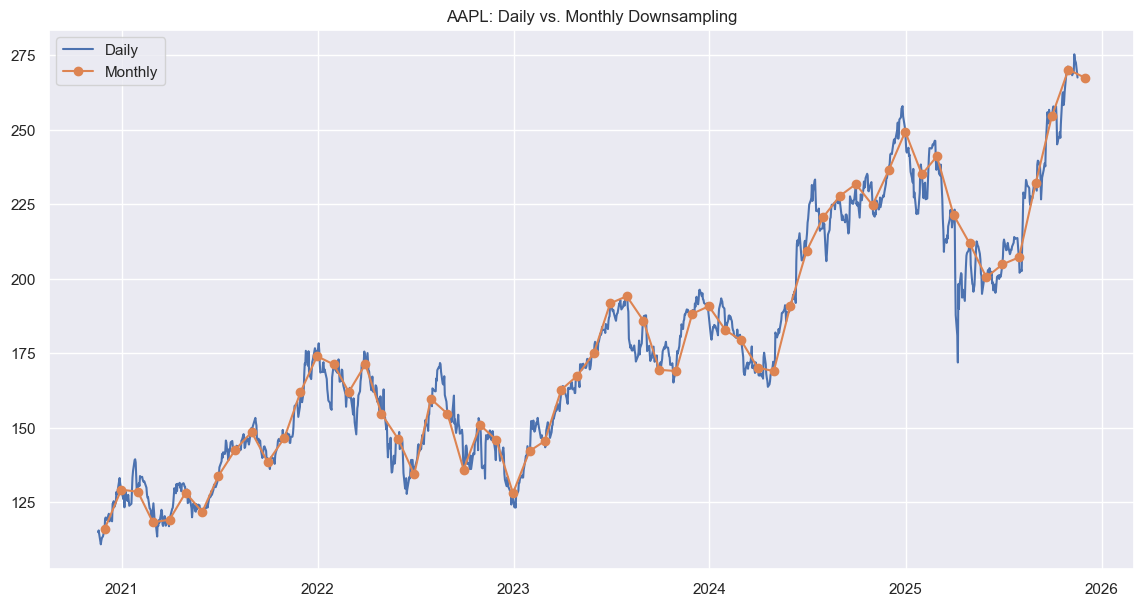

In [6]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(aapl['AAPL'], label = "Daily")
ax.plot(aapl_monthly, label = 'Monthly', marker = 'o')


plt.title('AAPL: Daily vs. Monthly Downsampling')
plt.legend()
plt.show()

- **Observation (Downsampling):** Downsampling is useful for seeing long-term trends and removing daily noise.

### 1.6. Returns

- **Concept:** Returns measure the percentage change in price. This is the most important unit in finance, more so than absolute price.
- **Formula (Simple Return):**
  $R_t = \frac{P_t - P_{t-1}}{P_{t-1}} = \frac{P_t}{P_{t-1}} - 1$
- **Tool:** `series.pct_change()`
- **Formula (Log Return):** (Useful for its additive properties)
  $r_t = \ln(\frac{P_t}{P_{t-1}}) = \ln(P_t) - \ln(P_{t-1})$
- **Tool:** `np.log(series / series.shift(1))`
- **Code (Simple Return):**

In [21]:
# Use SPY as an example
spy = intro_raw_data[['SPY']].copy().dropna()

# 1. Calculate Simple Return
spy['Returns_Simple'] = spy['SPY'].pct_change()

# 2. Calculate Log Return
spy['Returns_Log'] = np.log(spy['SPY'] / spy['SPY'].shift(1))

# Drop the first NA row (from .pct_change() and .shift())
spy = spy.dropna()

print(spy.head())

Ticker             SPY  Returns_Simple  Returns_Log
Date                                               
2020-11-19  333.544281        0.004210     0.004201
2020-11-20  331.260284       -0.006848    -0.006871
2020-11-23  333.245911        0.005994     0.005976
2020-11-24  338.615753        0.016114     0.015985
2020-11-25  338.093750       -0.001542    -0.001543


- **Visualization (Returns):**

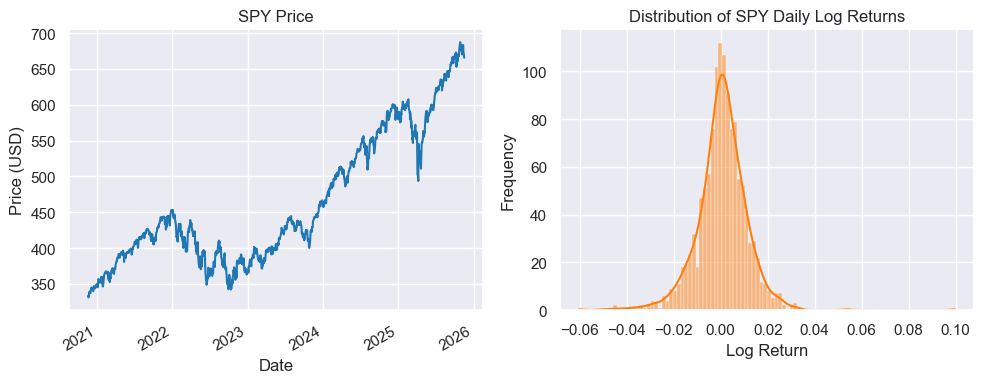

In [26]:
# Price chart and histogram of SPY log returns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Price plot
spy['SPY'].plot(ax=ax1, title='SPY Price', color='tab:blue')
ax1.set_ylabel('Price (USD)')
ax1.grid(True)

# Histogram of log returns
sns.histplot(spy['Returns_Log'].dropna(), bins=100, kde=True, ax=ax2, color='tab:orange')
ax2.set_title('Distribution of SPY Daily Log Returns')
ax2.set_xlabel('Log Return')
ax2.set_ylabel('Frequency')
ax2.grid(True)

plt.tight_layout()
plt.show()

- **Observation:** Plot 1 shows the price is trended (non-stationary). Plot 2 shows the returns are **stationary** (reverting around 0) and have fat tails - characteristic of financial data.

### 1.7. Rolling Statistics

- **Concept:** Calculating a statistic (like mean, std dev) on a fixed-size **'window'** of data, then sliding that window over the entire time series.
- **Tool:** `series.rolling(window=k)`: Creates a Rolling object.
- **Applied Functions:** `.mean()`, `.std()`, `.sum()`, `.corr()`.

---

#### 1.7.1. Simple Moving Average (SMA)

- **Concept:** The average of the last $k$ data points.
- **Use:** Smooths short-term price data to highlight long-term trends.
- **Formula:** $SMA_t(k) = \frac{1}{k} \sum_{i=0}^{k-1} P_{t-i}$
- **Tool:** `series.rolling(window=k).mean()`
- **Code:**

Visualizing SPY 50 and 200 SMA (Last 2 years):


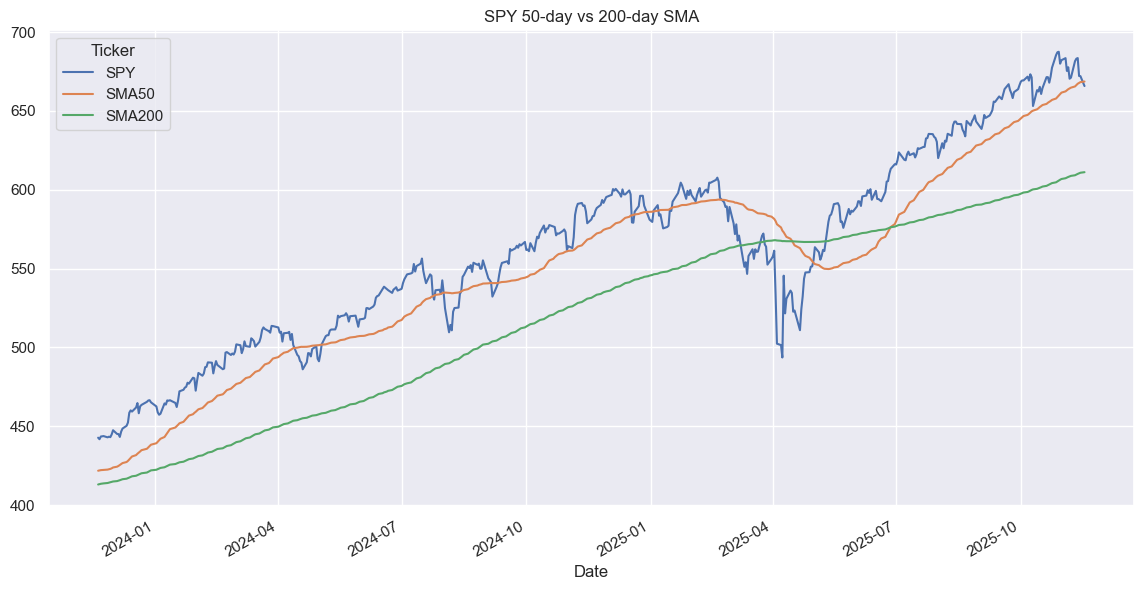

In [9]:
# Calculate 50-day and 200-day SMA for SPY
spy['SMA50'] = spy['SPY'].rolling(window=50).mean()
spy['SMA200'] = spy['SPY'].rolling(window=200).mean()

# Visualize SMA (only last 2 years for clarity)
print("Visualizing SPY 50 and 200 SMA (Last 2 years):")
spy.iloc[-500:][['SPY', 'SMA50', 'SMA200']].plot(title='SPY 50-day vs 200-day SMA', figsize=(14, 7))
plt.show()

- **Observation:** When the short SMA (50) crosses above the long SMA (200), it signals an uptrend (Golden Cross). When it crosses below, it signals a downtrend (Death Cross).

#### 1.7.2. Rolling Volatility

- **Concept:** A measure of risk, showing the dispersion of returns. We calculate it as the **standard deviation** of returns in a rolling window.
- **Formula (Sample Std Dev):** $\sigma_t(k) = \sqrt{\frac{1}{k-1} \sum_{i=0}^{k-1} (r_{t-i} - \bar{r}_t)^2}$
- **Annualizing:** $\sigma_{annual} = \sigma_{daily} \times \sqrt{252}$
- **Tool:** `series_returns.rolling(window=k).std() * np.sqrt(252)`
- **Code:**

Visualizing SPY 21-day Rolling Volatility (Annualized):


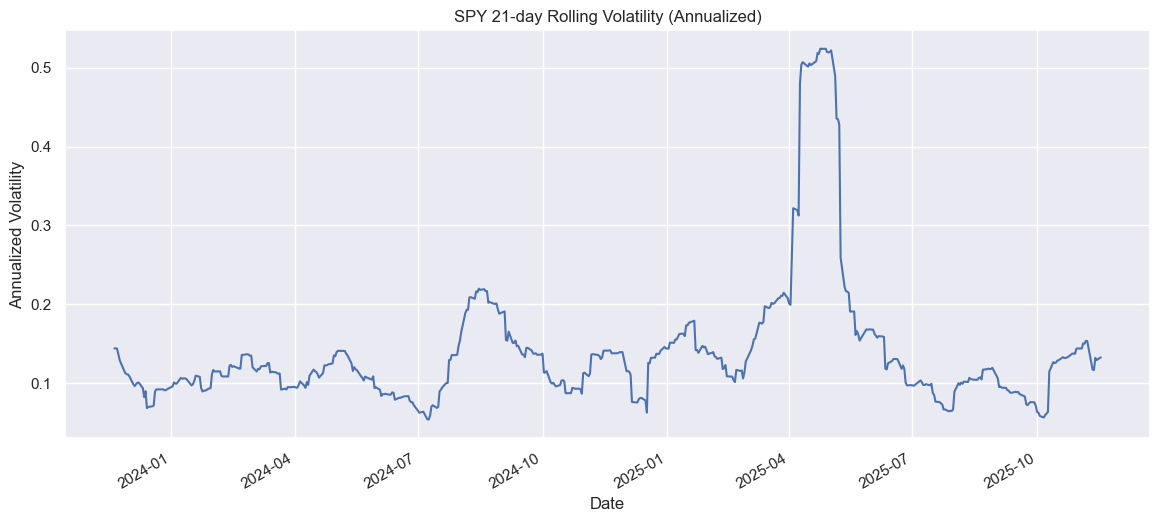

In [10]:
# Calculate 21-day rolling std dev of Log Returns
# (21 trading days ~ 1 month)
# Multiply by sqrt(252) (trading days in a year) to *annualize* it
spy['Volatility'] = spy['Returns_Log'].rolling(window=21).std() * np.sqrt(252)

print("Visualizing SPY 21-day Rolling Volatility (Annualized):")
spy['Volatility'].iloc[-500:].plot(title='SPY 21-day Rolling Volatility (Annualized)', figsize=(14, 6))
plt.ylabel('Annualized Volatility')
plt.show()

- **Observation:** The plot shows periods of calm (low volatility) and periods of storm (high volatility, e.g., the 2020 COVID-19 crisis).

#### 1.7.3. Rolling Correlation

- **Concept:** Measures how two assets move together (from -1 to 1) and how this relationship changes over time. This is the core concept of **Diversification**.
- **Tool:** `series1.rolling(window=k).corr(series2)`
- **Code:**

Visualizing 60-day Rolling Correlation (AAPL vs SPY):


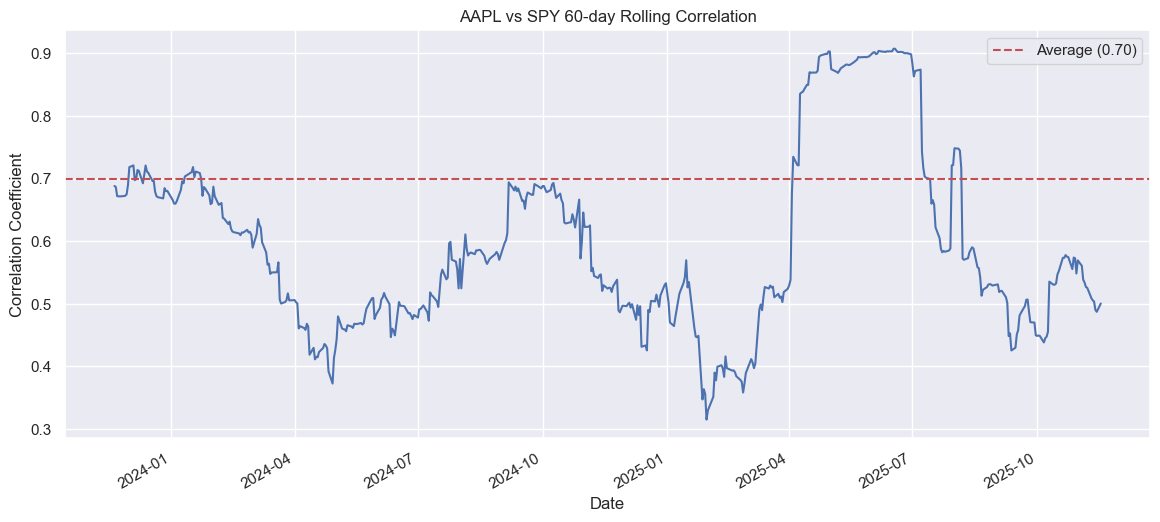

In [11]:
# Get log returns for AAPL and SPY (the market)
market_returns = np.log(intro_raw_data['SPY'] / intro_raw_data['SPY'].shift(1))
stock_returns = np.log(intro_raw_data['AAPL'] / intro_raw_data['AAPL'].shift(1))

# Calculate 60-day rolling correlation (~ 3 months)
rolling_corr = stock_returns.rolling(window=60).corr(market_returns)
rolling_corr = rolling_corr.dropna()

print("Visualizing 60-day Rolling Correlation (AAPL vs SPY):")
rolling_corr.iloc[-500:].plot(title='AAPL vs SPY 60-day Rolling Correlation', figsize=(14, 6))
plt.ylabel('Correlation Coefficient')
plt.axhline(rolling_corr.mean(), color='r', linestyle='--', label=f'Average ({rolling_corr.mean():.2f})')
plt.legend()
plt.show()

- **Observation:** The correlation between AAPL and SPY is not fixed. In Part 2, we will optimize portfolios based on these correlations.

## PART 2: PORTFOLIO OPTIMIZATION

### 2.1. Load Data and Train-Test Split

End of the foundational section. Now, we load data for our Train/Test model.
- **Total Period:** 2 years + 1 month (Example: 1/1/2023 - 1/31/2025)
- **Train Set:** 1/1/2023 - 12/31/2024 (2 years for Training)
- **Test Set:** 1/1/2025 - 1/31/2025 (1 month for Testing)

In [12]:
all_tickers = ['AAPL', 'MSFT', 'GOOGL', 'SPY']
n = len(all_tickers)
risk_free_rate = 0.02

# 1. Define time periods
# (Note: We use fixed dates to ensure the lecture is reproducible)
start_date_total = "2023-01-01"
end_date_total = "2025-01-31"
split_date = "2024-12-31" # Last day of the Train set

print(f"--- PREPARING DATA FOR PART 2 ---")
print(f"Reloading data for {n} tickers: {all_tickers}")
print(f"Total period: {start_date_total} to {end_date_total}")

try:
    # Load all data
    full_data = yf.download(all_tickers, start=start_date_total, end=end_date_total)['Close']
    full_data = full_data.ffill().dropna()
    
    if full_data.empty:
        raise ValueError("Failed to load data.")

    # 3. Split data into Train/Test
    train_data = full_data.loc[:split_date]
    test_data = full_data.loc[split_date:].iloc[1:] # Drop first day of test to avoid overlap
    
    print("\nData loaded and split successfully.")
    print(f"Total data: {len(full_data)} days")
    print(f"Train Set: {train_data.index.min().date()} -> {train_data.index.max().date()} ({len(train_data)} days)")
    print(f"Test Set:  {test_data.index.min().date()} -> {test_data.index.max().date()} ({len(test_data)} days)")

except Exception as e:
    print(f"ERROR: {e}")

--- PREPARING DATA FOR PART 2 ---
Reloading data for 4 tickers: ['AAPL', 'MSFT', 'GOOGL', 'SPY']
Total period: 2023-01-01 to 2025-01-31


C:\Users\Admin\AppData\Local\Temp\ipykernel_14072\2353065272.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  full_data = yf.download(all_tickers, start=start_date_total, end=end_date_total)['Close']
[*********************100%***********************]  4 of 4 completed


Data loaded and split successfully.
Total data: 521 days
Train Set: 2023-01-03 -> 2024-12-31 (502 days)
Test Set:  2025-01-02 -> 2025-01-30 (19 days)


### 2.2: Calculate Expected Returns (mu) and Risk (S) *on Train Set*

This is the "Training" step. All base calculations (mu, S) are **ONLY** allowed on the `train_data`.

In [13]:
# 1. Calculate Expected Returns (mu) ONLY ON TRAIN SET
mu_train = expected_returns.mean_historical_return(train_data, frequency=252)

# 2. Calculate Covariance Matrix (S) ONLY ON TRAIN SET
S_train = risk_models.sample_cov(train_data, frequency=252)

print("--- EXPECTED RETURNS (mu) FROM TRAIN SET ---")
print(mu_train)
print("\n--- RISK MATRIX (S) FROM TRAIN SET ---")
print(S_train.round(4))

--- EXPECTED RETURNS (mu) FROM TRAIN SET ---
Ticker
AAPL     0.425430
GOOGL    0.463382
MSFT     0.339565
SPY      0.259675
dtype: float64

--- RISK MATRIX (S) FROM TRAIN SET ---
Ticker    AAPL   GOOGL    MSFT     SPY
Ticker                                
AAPL    0.0456  0.0275  0.0245  0.0171
GOOGL   0.0275  0.0854  0.0355  0.0216
MSFT    0.0245  0.0355  0.0514  0.0194
SPY     0.0171  0.0216  0.0194  0.0164


### 2.3: (Training) Optimize n-assets (Max Sharpe) on Train Set

Find the best portfolio (balancing Return/Risk) using *all* $n=4$ assets, based on past data.

--- Training: Optimizing n-Assets (Max Sharpe) on Train Set ---
Static Weights found (n-MaxSharpe):
AAPL     0.38277
GOOGL    0.12924
MSFT     0.00000
SPY      0.48799
dtype: float64

Performance (In-Sample, on Train Set):
Expected annual return: 34.9%
Annual volatility: 15.4%
Sharpe Ratio: 2.13


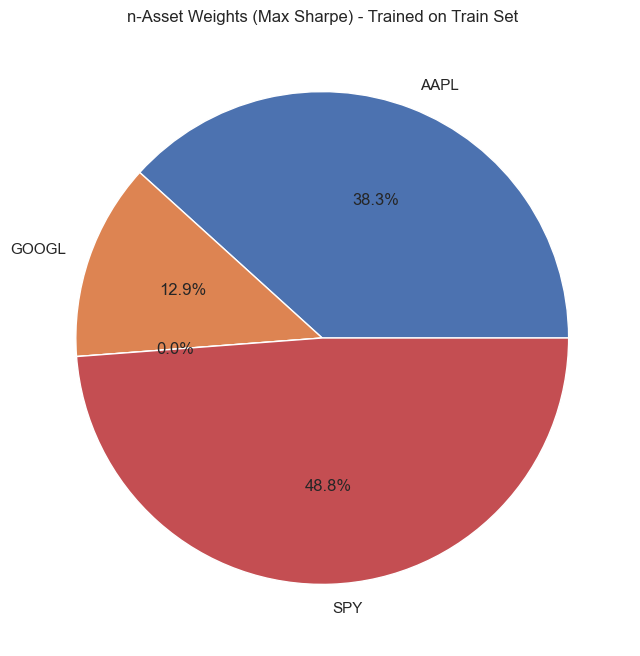

In [14]:
print("--- Training: Optimizing n-Assets (Max Sharpe) on Train Set ---")

# 1. Initialize object (with Train data)
ef_sharpe_n = EfficientFrontier(mu_train, S_train, weight_bounds=(0, 1))

# 2. Optimize
weights_sharpe_n = ef_sharpe_n.max_sharpe(risk_free_rate=risk_free_rate)
cleaned_weights_sharpe_n = ef_sharpe_n.clean_weights()

# 3. Print results
print("Static Weights found (n-MaxSharpe):")
print(pd.Series(cleaned_weights_sharpe_n))
print("\nPerformance (In-Sample, on Train Set):")
ef_sharpe_n.portfolio_performance(verbose=True, risk_free_rate=risk_free_rate)

# 4. Visualize (Pie Chart)
fig, ax = plt.subplots(figsize=(8, 8))
pd.Series(cleaned_weights_sharpe_n).plot.pie(
    ax=ax, 
    autopct='%1.1f%%', 
    title='n-Asset Weights (Max Sharpe) - Trained on Train Set'
)
ax.set_ylabel('')
plt.show()

### 2.4: (Training) Optimize n-assets (Min Volatility) on Train Set

Find the safest (lowest risk) portfolio using *all* $n=4$ assets, based on past data.

--- Training: Optimizing n-Assets (Min Volatility) on Train Set ---
Static Weights found (n-MinVol):
AAPL     0.0
GOOGL    0.0
MSFT     0.0
SPY      1.0
dtype: float64

Performance (In-Sample, on Train Set):
Expected annual return: 26.0%
Annual volatility: 12.8%
Sharpe Ratio: 1.87


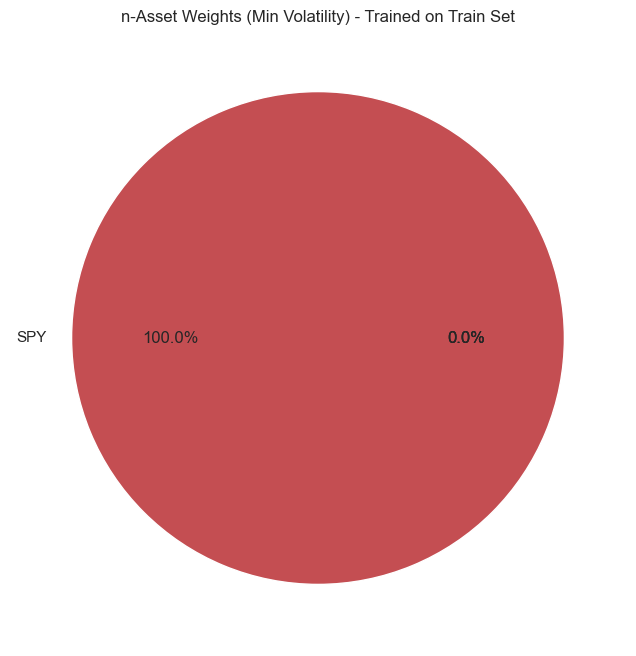

In [15]:
print("--- Training: Optimizing n-Assets (Min Volatility) on Train Set ---")

# 1. Initialize object (with Train data)
ef_vol_n = EfficientFrontier(mu_train, S_train, weight_bounds=(0, 1))

# 2. Optimize
weights_vol_n = ef_vol_n.min_volatility()
cleaned_weights_vol_n = ef_vol_n.clean_weights()

# 3. Print results
print("Static Weights found (n-MinVol):")
print(pd.Series(cleaned_weights_vol_n))
print("\nPerformance (In-Sample, on Train Set):")
ef_vol_n.portfolio_performance(verbose=True, risk_free_rate=risk_free_rate)

# 4. Visualize (Pie Chart)
fig, ax = plt.subplots(figsize=(8, 8))
pd.Series(cleaned_weights_vol_n).plot.pie(
    ax=ax, 
    autopct='%1.1f%%', 
    title='n-Asset Weights (Min Volatility) - Trained on Train Set'
)
ax.set_ylabel('')
plt.show()

### 2.5: Definition & Visualization of the Efficient Frontier (on Train Set)

- **Definition (Efficient Frontier):** The Efficient Frontier is a curve representing the set of "optimal" portfolios (based on the input data, here `train_data`).
- For any point on the frontier:
  1. No other portfolio exists with the same risk that offers a higher return.
  2. No other portfolio exists with the same return that has lower risk.
- All portfolios *below* the frontier are sub-optimal.

d:\CODE\env-teaching\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


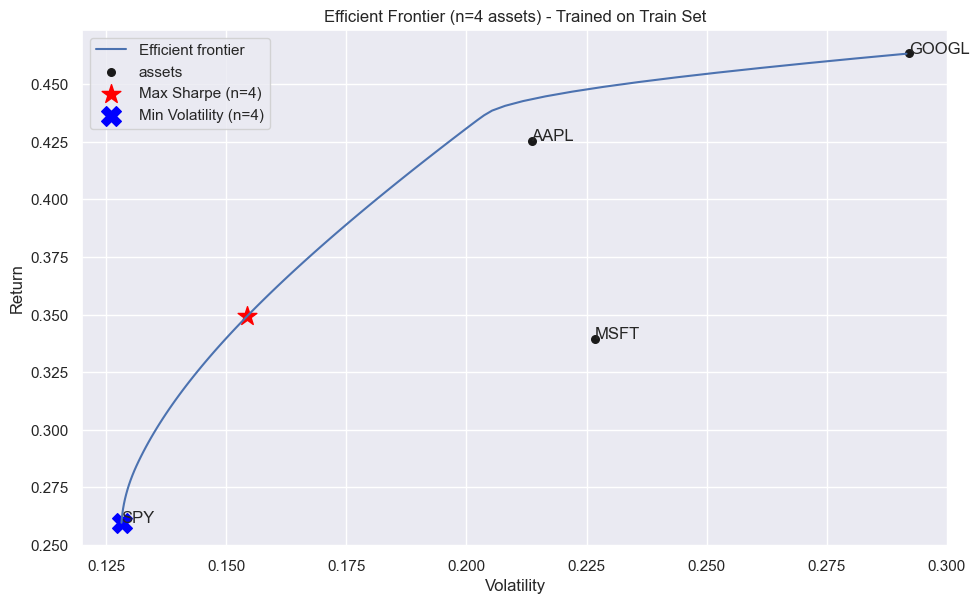

In [16]:
# Plot all optimal portfolios (based on n=4 assets from train_data)
ef_plot_n = EfficientFrontier(mu_train, S_train, weight_bounds=(0, 1))

fig, ax = plt.subplots(figsize=(10, 6))
plotting.plot_efficient_frontier(ef_plot_n, ax=ax, show_assets=True, show_tickers=True)

# Add the points we found (from 2.3 and 2.4)
ax.scatter(ef_sharpe_n.portfolio_performance()[1], ef_sharpe_n.portfolio_performance()[0], marker="*", s=200, c="red", label="Max Sharpe (n=4)")
ax.scatter(ef_vol_n.portfolio_performance()[1], ef_vol_n.portfolio_performance()[0], marker="X", s=200, c="blue", label="Min Volatility (n=4)")

ax.set_title(f"Efficient Frontier (n={n} assets) - Trained on Train Set")
ax.legend()
plt.show()

#### Observation (Part 2.2 - 2.5)

- The charts above show the optimization results *based only on the Train Set* (2 years of history).
- **Max Sharpe:** The Max Sharpe portfolio (red star) tries to balance risk and return.
- **Min Volatility:** The Min Vol portfolio (blue X) focuses only on minimizing risk.
- **Problem:** This is an "in-sample" result. We will check how these weights perform on the `test_data` in section 2.8.

### 2.6: (Training) Optimize $k$-of-$n$ assets (Max Sharpe) on Train Set

We will loop through all 15 combinations to find the $k$ tickers (and weights) that give the highest Sharpe Ratio, **using only `train_data`**.

In [17]:
print(f"--- STARTING k-of-n SEARCH (Max Sharpe) on Train Set ---")

# 1. Global tracking variables
global_best_sharpe_k = -np.inf
global_best_weights_k_sharpe = None
all_results_sharpe = [] 

# 2. Calculate base metrics (from mu_train, S_train already calculated in 2.2)
individual_vol_series_train = pd.Series(np.sqrt(np.diag(S_train)), index=all_tickers)
individual_sharpes_train = (mu_train - risk_free_rate) / individual_vol_series_train
individual_vol_train = individual_vol_series_train.to_dict()

# 3. Outer loop: Iterate k from 1 to n
for k in range(1, n + 1):
    # 4. Inner loop: Iterate combinations C(n, k)
    for combo in itertools.combinations(all_tickers, k):
        combo_list = list(combo)
        combo_str = str(combo)
        ret, vol, sharpe, weights_dict = (np.nan, np.nan, np.nan, {})

        try:
            # 5. Optimize for this combination
            if k == 1:
                ticker = combo_list[0]
                ret = mu_train[ticker]
                vol = individual_vol_train[ticker]
                sharpe = individual_sharpes_train[ticker]
                weights_dict = {ticker: 1.0}
            else:
                mu_combo = mu_train[combo_list]
                S_combo = S_train.loc[combo_list, combo_list]
                ef_combo = EfficientFrontier(mu_combo, S_combo, weight_bounds=(0, 1))
                weights = ef_combo.max_sharpe(risk_free_rate=risk_free_rate)
                ret, vol, sharpe = ef_combo.portfolio_performance(risk_free_rate=risk_free_rate)
                weights_dict = ef_combo.clean_weights()

            # 6. Track results
            if sharpe > global_best_sharpe_k:
                global_best_sharpe_k = sharpe
                global_best_weights_k_sharpe = weights_dict
            
            all_results_sharpe.append({'k': k, 'Combination': combo_str, 'Sharpe': sharpe, 'Volatility': vol, 'Return (APY)': ret, 'Weights': weights_dict})
        except Exception as e:
            pass 

# 7. Print final results
print("\n================ OPTIMAL RESULT (k-Max Sharpe) - TRAINING ================")
print(f"Highest Global Sharpe: {global_best_sharpe_k:.4f} (with k={len(global_best_weights_k_sharpe)}) ")
print("Static Weights found (k-MaxSharpe):")
print(pd.Series(global_best_weights_k_sharpe))

# 8. Print all results dataframe
all_results_sharpe_df = pd.DataFrame(all_results_sharpe).sort_values(by='Sharpe', ascending=False).reset_index(drop=True)
print("\n--- Top 15 Combinations (Ranked by Sharpe) ---")
print(all_results_sharpe_df[['k', 'Combination', 'Sharpe', 'Volatility']].head())

--- STARTING k-of-n SEARCH (Max Sharpe) on Train Set ---

================ OPTIMAL RESULT (k-Max Sharpe) - TRAINING ================
Highest Global Sharpe: 2.1339 (with k=3) 
Static Weights found (k-MaxSharpe):
AAPL     0.38277
GOOGL    0.12924
SPY      0.48799
dtype: float64

--- Top 15 Combinations (Ranked by Sharpe) ---
   k                       Combination    Sharpe  Volatility
0  4  ('AAPL', 'MSFT', 'GOOGL', 'SPY')  2.133862    0.154391
1  3          ('AAPL', 'GOOGL', 'SPY')  2.133862    0.154391
2  3           ('AAPL', 'MSFT', 'SPY')  2.092809    0.146434
3  2                   ('AAPL', 'SPY')  2.091518    0.145558
4  3         ('AAPL', 'MSFT', 'GOOGL')  2.058132    0.196176


### 2.7: (Training) Optimize $k$-of-$n$ assets (Min Volatility) on Train Set

Same as 2.6, but finding the $k$ tickers with the lowest Risk.

In [18]:
print(f"--- STARTING k-of-n SEARCH (Min Volatility) on Train Set ---")

# 1. Global tracking variables
global_best_vol_k = np.inf
global_best_weights_k_vol = None
all_results_vol = [] 

# (No need to recalculate individual_vol_train, use from 2.6)

# 3. Outer loop: Iterate k from 1 to n
for k in range(1, n + 1):
    # 4. Inner loop: Iterate combinations C(n, k)
    for combo in itertools.combinations(all_tickers, k):
        combo_list = list(combo)
        combo_str = str(combo)
        ret, vol, sharpe, weights_dict = (np.nan, np.nan, np.nan, {})

        try:
            if k == 1:
                ticker = combo_list[0]
                ret = mu_train[ticker]
                vol = individual_vol_train[ticker]
                sharpe = individual_sharpes_train[ticker]
                weights_dict = {ticker: 1.0}
            else:
                mu_combo = mu_train[combo_list]
                S_combo = S_train.loc[combo_list, combo_list]
                ef_combo = EfficientFrontier(mu_combo, S_combo, weight_bounds=(0, 1))
                weights = ef_combo.min_volatility() # <-- CHANGE OBJECTIVE
                ret, vol, sharpe = ef_combo.portfolio_performance(risk_free_rate=risk_free_rate)
                weights_dict = ef_combo.clean_weights()

            # 6. Track results (CHANGE OBJECTIVE)
            if vol < global_best_vol_k:
                global_best_vol_k = vol
                global_best_weights_k_vol = weights_dict
            
            all_results_vol.append({'k': k, 'Combination': combo_str, 'Sharpe': sharpe, 'Volatility': vol, 'Return (APY)': ret, 'Weights': weights_dict})
        except Exception as e:
            pass 

# 7. Print final results
print("\n================ OPTIMAL RESULT (k-Min Vol) - TRAINING ================")
print(f"Lowest Global Volatility: {global_best_vol_k:.4f} (with k={len(global_best_weights_k_vol)}) ")
print("Static Weights found (k-MinVol):")
print(pd.Series(global_best_weights_k_vol))

# 8. Print all results dataframe
all_results_vol_df = pd.DataFrame(all_results_vol).sort_values(by='Volatility', ascending=True).reset_index(drop=True)
print("\n--- Top 15 Combinations (Ranked by Volatility) ---")
print(all_results_vol_df[['k', 'Combination', 'Volatility', 'Sharpe']].head())

--- STARTING k-of-n SEARCH (Min Volatility) on Train Set ---

================ OPTIMAL RESULT (k-Min Vol) - TRAINING ================
Lowest Global Volatility: 0.1282 (with k=1) 
Static Weights found (k-MinVol):
SPY    1.0
dtype: float64

--- Top 15 Combinations (Ranked by Volatility) ---
   k               Combination  Volatility    Sharpe
0  1                  ('SPY',)    0.128186  1.869744
1  2          ('GOOGL', 'SPY')    0.128186  1.869744
2  2           ('MSFT', 'SPY')    0.128186  1.869744
3  3  ('MSFT', 'GOOGL', 'SPY')    0.128186  1.869744
4  2           ('AAPL', 'SPY')    0.128186  1.869744


### 2.8: Performance Comparison (Out-of-Sample) on Test Set

This is the critical test. We will now apply the 5 sets of "Static Weights" we just trained (on `train_data`) to the `test_data` (1 month of "future" data) to see how they actually perform.

--- STARTING STATIC TEST (Out-of-Sample) ---
Testing on 19 days (Test Set)

--- Plotting Cumulative Performance (Out-of-Sample) ---


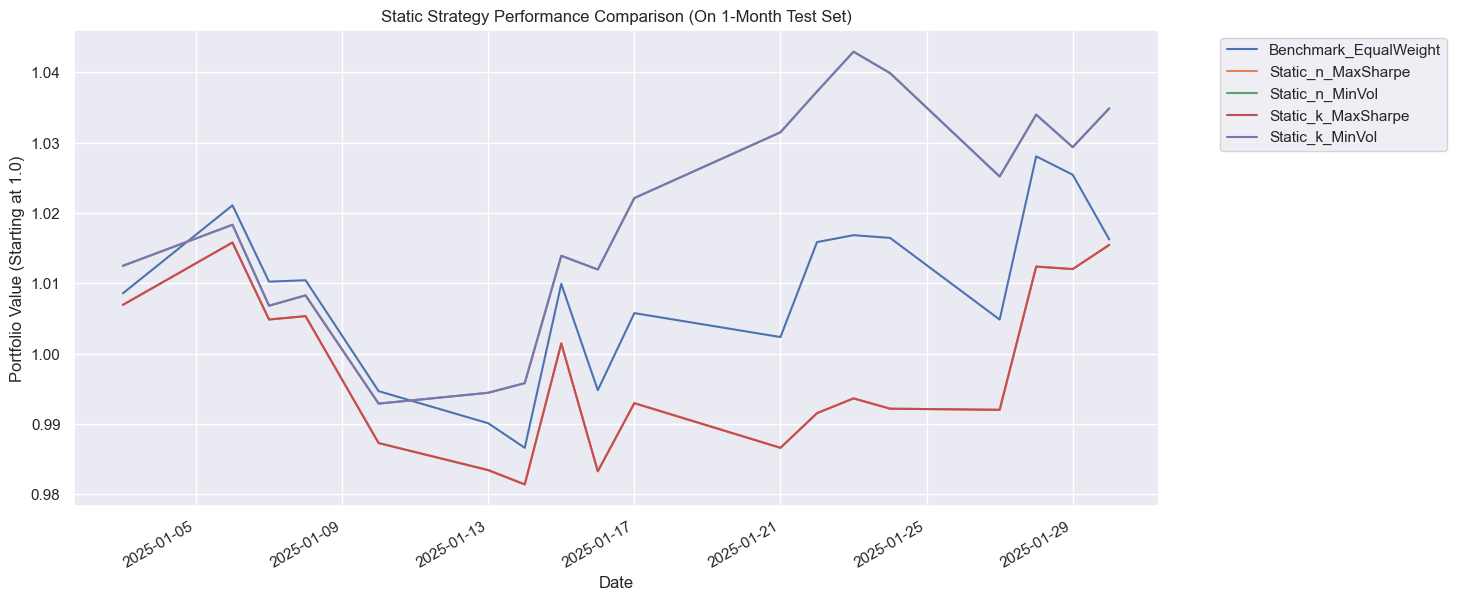

In [19]:
print(f"--- STARTING STATIC TEST (Out-of-Sample) ---")
print(f"Testing on {len(test_data)} days (Test Set)")

# Get Test Set prices
test_prices = test_data.copy()
# Get daily returns (using pct_change for consistency)
test_returns = test_prices.pct_change().dropna()

# DataFrame to store daily returns of each strategy
static_returns_df = pd.DataFrame(index=test_returns.index)

# --- 1. Benchmark: Equal-Weighted ---
equal_weights = {ticker: (1/n) for ticker in all_tickers}
static_returns_df['Benchmark_EqualWeight'] = (test_returns * pd.Series(equal_weights)).sum(axis=1)

# --- 2. Static n-MaxSharpe (From 2.3) ---
static_returns_df['Static_n_MaxSharpe'] = (test_returns * pd.Series(cleaned_weights_sharpe_n)).sum(axis=1)

# --- 3. Static n-MinVol (From 2.4) ---
static_returns_df['Static_n_MinVol'] = (test_returns * pd.Series(cleaned_weights_vol_n)).sum(axis=1)

# --- 4. Static k-MaxSharpe (From 2.6) ---
static_returns_df['Static_k_MaxSharpe'] = (test_returns[global_best_weights_k_sharpe.keys()] * pd.Series(global_best_weights_k_sharpe)).sum(axis=1)

# --- 5. Static k-MinVol (From 2.7) ---
static_returns_df['Static_k_MinVol'] = (test_returns[global_best_weights_k_vol.keys()] * pd.Series(global_best_weights_k_vol)).sum(axis=1)

# 6. Visualize Cumulative Performance (Static)
print("\n--- Plotting Cumulative Performance (Out-of-Sample) ---")
static_cumulative_returns = (1 + static_returns_df).cumprod()
static_cumulative_returns.plot(figsize=(14, 7), title='Static Strategy Performance Comparison (On 1-Month Test Set)')
plt.ylabel('Portfolio Value (Starting at 1.0)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### 2.9: Metrics Analysis & Conclusion (Test Set)

Compare the metrics of the 5 strategies on the test set.

In [20]:
# Performance metrics function (uses simple returns)
def calculate_performance_metrics_simple(portfolio_value_series, risk_free_rate=0.02):
    simple_returns = portfolio_value_series.pct_change().dropna()
    if simple_returns.empty or simple_returns.std() == 0:
        return pd.Series({"Annualized Return (APY)": 0,"Annualized Volatility": 0,"Sharpe Ratio (rf=2%)": 0,"Max Drawdown": 0})
    mean_return_daily = simple_returns.mean()
    annualized_return_pct = (1 + mean_return_daily) ** 252 - 1
    volatility_daily = simple_returns.std()
    annualized_volatility = volatility_daily * np.sqrt(252)
    sharpe_ratio = (annualized_return_pct - risk_free_rate) / annualized_volatility
    cumulative_returns_pct = (1 + simple_returns).cumprod()
    cumulative_max = cumulative_returns_pct.cummax()
    drawdown = (cumulative_returns_pct - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()
    if np.isnan(max_drawdown): max_drawdown = 0.0
    metrics = {"Annualized Return (APY)": annualized_return_pct,"Annualized Volatility": annualized_volatility,"Sharpe Ratio (rf=2%)": sharpe_ratio,"Max Drawdown": max_drawdown}
    return pd.Series(metrics)

# Calculate metrics for all 5 strategies
all_metrics = {}
for strategy in static_cumulative_returns.columns:
    all_metrics[strategy] = calculate_performance_metrics_simple(static_cumulative_returns[strategy])

metrics_df = pd.DataFrame(all_metrics).T 

print(f"--- FINAL METRICS COMPARISON (Out-of-Sample Test - {len(test_data)} days) ---")
print(metrics_df.sort_values(by='Sharpe Ratio (rf=2%)', ascending=False).to_string(float_format="{:.2%}".format))


--- FINAL METRICS COMPARISON (Out-of-Sample Test - 19 days) ---
                       Annualized Return (APY)  Annualized Volatility  Sharpe Ratio (rf=2%)  Max Drawdown
Static_n_MinVol                         39.62%                 14.21%               264.67%        -2.50%
Static_k_MinVol                         39.62%                 14.21%               264.67%        -2.50%
Static_n_MaxSharpe                      14.92%                 17.21%                75.06%        -3.39%
Static_k_MaxSharpe                      14.92%                 17.21%                75.06%        -3.39%
Benchmark_EqualWeight                   13.86%                 19.40%                61.12%        -3.38%


### Observation (Conclusion for Part 2)

- **Result:** The table above shows the objective comparison of the 5 strategies on the 1-month test set.
- **Analysis:** (Results may vary). Often, the Min Volatility strategies (both $n$ and $k$) will show stability and a low Max Drawdown. The Max Sharpe strategies, which were trained to maximize return/risk in the past (Train Set), may perform very well or very poorly in the Test Set, depending on market conditions.
- **Conclusion:** This is a fundamental workflow for "out-of-sample" testing. It demonstrates that the "best" portfolio from the past (in-sample) is not guaranteed to be the best in the future (out-of-sample).

# SUMMARY

In this lecture, we have built a quantitative financial analysis workflow:

1.  **Part 1 (Foundations):** Built a detailed lecture on core time series concepts (Resampling, Returns, SMA, Volatility, Correlation).

2.  **Part 2 (Optimization & Testing):** 
    * Established an objective **Train/Test** workflow (2 years Train, 1 month Test).
    * Used sequential code (no functions) to **Train** optimization models (n-Sharpe, n-Vol, k-Sharpe, k-Vol) *only on the Train Set*.
    * **Tested** 5 strategies (including Benchmark) objectively *only on the Test Set*.
    * Compared the results using both charts and a metrics table (Sharpe, APY, Max Drawdown) to find the best "out-of-sample" strategy.

# REFERENCES

1.  **Hilpisch, Yves (2018). "Python for Finance: Mastering Data-Driven Finance". O'Reilly Media.**
    *(Main content for Part 1 and Backtesting theory)*

2.  **McKinney, Wes (2022). "Python for Data Analysis: Data Wrangling with pandas, NumPy, and Jupyter". O'Reilly Media.**
    *(Supplementary content for Part 1 - Time Series Analysis)*

3.  **PyPortfolioOpt Documentation:**
    *https://pyportfolioopt.readthedocs.io/*
    *(Main content for Part 2 - Portfolio Optimization)*

4.  **(Advanced) López de Prado, Marcos (2018). "Advances in Financial Machine Learning". Wiley.**
    *(Reference for robust backtesting theory)*